In [3]:
import math
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

# Load and encode data
df = pd.read_csv("data/conjoint_data.csv")
dfe = pd.get_dummies(df, columns=["brand"], drop_first=True)
dfe['ad'] = dfe['ad'] == 'Yes'

X = dfe[["brand_N", "brand_P", "ad", "price"]].values
y = dfe["choice"].values
groups = (dfe["resp"].astype(str) + "-" + dfe["task"].astype(str)).factorize()[0]

# Log-likelihood using math.exp
def log_likelihood(beta, X, y, groups):
    ll = 0.0
    for g in np.unique(groups):
        idx = groups == g
        Xg = X[idx]
        yg = y[idx]
        U = np.dot(Xg, beta)
        maxU = max(U)  # for numerical stability
        expU = [math.exp(u - maxU) for u in U]
        denom = sum(expU)
        probs = [eu / denom for eu in expU]
        chosen_idx = np.argmax(yg)
        ll += math.log(probs[chosen_idx])
    return -ll

# Run optimization
init_beta = np.zeros(X.shape[1])
res = minimize(log_likelihood, init_beta, args=(X, y, groups), method="BFGS")



In [5]:
beta_hat = res.x
ci = 0.95

# Standard errors from inverse Hessian
hessian_inv = res.hess_inv
se = np.sqrt(np.diag(hessian_inv))

# 95% confidence interval bounds
z = norm.ppf(1-((1-ci)/2))
ci_lower = beta_hat - z * se
ci_upper = beta_hat + z * se

# Output results
for name, b, s, low, high in zip(['brand_N', 'brand_P', 'ad', 'price'], beta_hat, se, ci_lower, ci_upper):
    print(f"{name}: {b:.4f} ± {z:.2f}×{s:.4f} → CI: [{low:.4f}, {high:.4f}]")

brand_N: 0.9412 ± 1.96×0.0201 → CI: [0.9017, 0.9807]
brand_P: 0.5016 ± 1.96×0.0107 → CI: [0.4806, 0.5226]
ad: -0.7320 ± 1.96×0.0060 → CI: [-0.7437, -0.7203]
price: -0.0995 ± 1.96×0.0061 → CI: [-0.1115, -0.0875]


In [ ]:
def log_prior(beta):
    lp = 0.0
    lp += sum(norm.logpdf(beta[:3], loc=0, scale=np.sqrt(5)))
    lp += norm.logpdf(beta[3], loc=0, scale=1)
    return lp

def log_posterior(beta, X, y, groups):
    return -log_likelihood(beta, X, y, groups) + log_prior(beta)

n_draws = 11000
beta_draws = np.zeros((n_draws, 4))
beta_current = np.zeros(4)
logp_current = log_posterior(beta_current, X, y, groups)
proposal_sd = np.array([0.05, 0.05, 0.05, 0.005])

for i in range(n_draws):
    proposal = beta_current + np.random.normal(0, proposal_sd)
    logp_proposal = log_posterior(proposal, X, y, groups)
    accept_prob = np.exp(logp_proposal - logp_current)
    if np.random.rand() < accept_prob:
        beta_current = proposal
        logp_current = logp_proposal
    beta_draws[i, :] = beta_current

beta_posterior = beta_draws[1000:]

means = beta_posterior.mean(axis=0)
sds = beta_posterior.std(axis=0)
ci_lower = np.percentile(beta_posterior, 2.5, axis=0)
ci_upper = np.percentile(beta_posterior, 97.5, axis=0)

for name, m, s, lo, hi in zip(['brand_N', 'brand_P', 'ad', 'price'], means, sds, ci_lower, ci_upper):
    print(f'{name}: {m:.4f} ± {s:.4f} → CI: [{lo:.4f}, {hi:.4f}]')

import matplotlib.pyplot as plt
plt.plot(beta_posterior[:,3])
plt.title("Trace plot for price")
plt.show()

plt.hist(beta_posterior[:,3], bins=50)
plt.title("Posterior of price")
plt.show()


brand_N: 0.9426 ± 0.1103 → CI: [0.7282, 1.1616]
brand_P: 0.5127 ± 0.1127 → CI: [0.2781, 0.7293]
ad: -0.7327 ± 0.0885 → CI: [-0.9091, -0.5610]
price: -0.0998 ± 0.0064 → CI: [-0.1128, -0.0872]


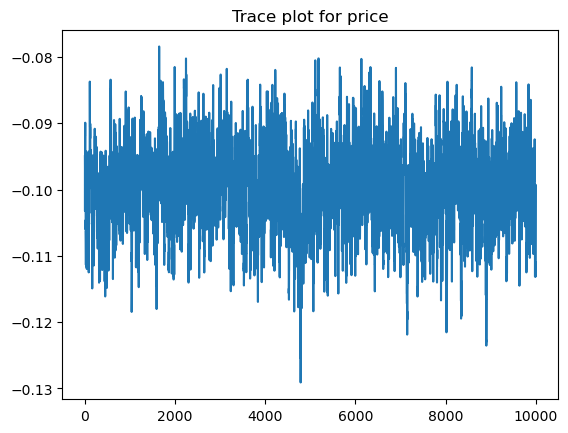

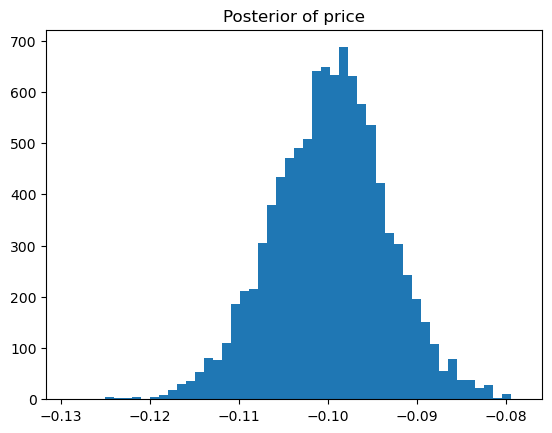

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = cycler(color=['#375a7f']) 
plt.plot(beta_posterior[:,3])
plt.title("Trace plot for price")
plt.show()

plt.hist(beta_posterior[:,3], bins=50)
plt.title("Posterior of price")
plt.show()